Acho que nesse caso um bom critério de comparação é Belo Horizonte. Isso é:

* Treinar o modelo apenas com os dados de BH e salvara a performance;
* Treinar o modelo com todos os municípios persistentes e retreinar para BH;
* Se o modelo global mostrar um ganho de performance aplicar ele para a série do estado e ver se fica melhor do que o modelo treinado apenas com o Estado. 

In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
from itertools import product
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

In [2]:
def transform_label(ep_label): 
    year_ep_label = int(ep_label[:4])
    week_ep_label = int(ep_label[4:])
    
    if week_ep_label <=40:
        new_week = 12 + week_ep_label
        new_year = year_ep_label
    
    else:
        new_week = week_ep_label - 40
        new_year = year_ep_label +1
    
    if new_week <=9:
        week_str = f'0{new_week}'
    else:
        week_str = str(new_week)

    new_ep_label = f'{new_year}{week_str}'

    return new_ep_label

Dados dos munícipios com transmissão persistente ou epidêmica

In [3]:
state = 'MG'

In [4]:
df_perfis = pd.read_csv('./data/perfis_final_10_22_sprint.csv',sep = ';')

df_perfis = df_perfis.loc[df_perfis.UF_ACR == state] 

df_perfis = df_perfis.loc[df_perfis.Perfil_dengue.isin(['Epidêmico',
       'Transmissão Persistente'])]

df_perfis

,code_muni,MUNI_NAME,UF_CODE,UF_ACR,UF_NAME,REGION,Perfil_dengue
256,3101102,Aimorés,31,MG,Minas Gerais,3,Epidêmico
261,3101607,Alfenas,31,MG,Minas Gerais,3,Epidêmico
282,3103405,Araçuaí,31,MG,Minas Gerais,3,Epidêmico
283,3103504,Araguari,31,MG,Minas Gerais,3,Epidêmico
289,3104007,Araxá,31,MG,Minas Gerais,3,Epidêmico
...,...,...,...,...,...,...,...
1071,3170404,Unaí,31,MG,Minas Gerais,3,Epidêmico
1079,3170701,Varginha,31,MG,Minas Gerais,3,Epidêmico
1081,3170800,Várzea da Palma,31,MG,Minas Gerais,3,Epidêmico
1088,3171204,Vespasiano,31,MG,Minas Gerais,3,Epidêmico


In [5]:
df = pd.read_csv('./data/dengue.csv.gz')

df = df.loc[df.uf == 'MG']

df.date = pd.to_datetime(df.date)

df.set_index('date', inplace = True)

df.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
date,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False


Agregando os casos do estado: 

In [6]:
def agg_data(df, geocode = None):

    if geocode is not None: 

        df = df.loc[df.geocode == geocode]
        
    df_w = df[['casos']]

    df_w = df_w.resample('W-SUN').sum()
    
    df_w['epiweek_label'] = [Week.fromdate(x) for x in df_w.index]
    
    df_w['epiweek_label'] = df_w['epiweek_label'].astype(str)
    
    df_w['epiweek_label'] = df_w['epiweek_label'].apply(transform_label)
    
    
    df_w['epiweek'] = df_w['epiweek_label'].astype(str).str[-2:].astype(int)
    df_w['year'] = df_w['epiweek_label'].astype(str).str[:4].astype(int)
    
    df_w['casos_totais'] = pd.NA
    
    for year in df_w.year.unique():
    
        df_w.loc[df_w.year == year, 'casos_totais'] = df_w.loc[(df_w.year == year)].casos.sum()
    
    return df_w
        

In [7]:
df_w = agg_data(df)
df_w.head()

,casos,epiweek_label,epiweek,year,casos_totais
date,,,,,
2010-01-03,2794,201013,13,2010,258066
2010-01-10,3729,201014,14,2010,258066
2010-01-17,4656,201015,15,2010,258066
2010-01-24,6195,201016,16,2010,258066
2010-01-31,7179,201017,17,2010,258066


Capturando os dados para cada uma das cidades com municípios persistentes

In [8]:
df_cap = agg_data(df, 3106200)

df_cap.head()

,casos,epiweek_label,epiweek,year,casos_totais
date,,,,,
2010-01-03,339,201013,13,2010,69331
2010-01-10,490,201014,14,2010,69331
2010-01-17,587,201015,15,2010,69331
2010-01-24,903,201016,16,2010,69331
2010-01-31,1140,201017,17,2010,69331


### Funções para o pré obtenção dos dados de treino e de teste: 

In [9]:
def get_train_data(df_w_train): 

    columns_to_normalize = ['casos', 'epiweek', 'casos_totais']

    norm_values = df_w_train.max()[columns_to_normalize]
    

    df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values
    
    min_year = df_w_train.index.year.min() + 2

    if min_year <=2012:
        min_year = 2013

    X_train = np.empty((0, 2, 3))
    
    y_train = np.empty((0, 1))
        
    for year, week in product(np.arange(min_year, df_w_train.index.year.max()), np.arange(1,53)): 
        
        if week <=9:
            week_str = f'0{week}'
        else:
            week_str = str(week)
        try:
            last_2 = np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year-2}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
        
            last_1 = np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year-1}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
        
            last_values = np.array(np.append(last_2, last_1, axis=1))
                
            X_train = np.append(X_train, last_values, axis = 0)
        
            y_train = np.append(y_train, np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year}{week_str}')][['casos']].values[0]]).reshape(1,-1),
                               axis = 0)

        except:
            print(year)
            print(week)
            pass 
            

    return X_train.astype(np.float32), y_train.astype(np.float32), norm_values 


def get_test_data(norm_values, df_w_test):
    '''
    Essa função gera os dados de teste apenas para uma ano específico. 
    '''

    norm_values = norm_values[['casos', 'epiweek', 'casos_totais']]

    df_w_test[['casos', 'epiweek', 'casos_totais']] = df_w_test[['casos', 'epiweek', 'casos_totais']]/norm_values

    year  = df_w_test.index.year.max()

    X_test = np.empty((0, 2, 3))
    
    y_test = np.empty((0, 1))
        
    for week in np.arange(1,53):

        if week <=9:
            week_str = f'0{week}'
        else:
            week_str = str(week)
            
        try:
            last_2 = np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year-2}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
            
            last_1 = np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year-1}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
            
            last_values = np.array(np.append(last_2, last_1, axis=1))
                    
            X_test = np.append(X_test, last_values, axis = 0)
            
            y_test = np.append(y_test, np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year}{week_str}')][['casos']].values[0]]).reshape(1,-1),
                                   axis = 0)
        except: 
            pass

    return X_test.astype(np.float32), y_test.astype(np.float32)
    

## Defining the model: 

In [10]:
from time import time
import tensorflow as tf
from keras import layers
import keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Attention, Dense, Dropout, Bidirectional, Flatten, Conv1D, Concatenate #, ConvLSTM1D, TimeDistributed
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, mean_squared_log_error, \
    median_absolute_error, r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.activations import gelu 
from keras.optimizers import Adam#, RMSprop

In [11]:
def build_baseline( hidden=8, features=100, predict_n=4, look_back=4, loss='msle', optimizer = 'adam',  stateful = False, batch_size = 1):

    inp = keras.Input(
        #shape=(look_back, features),
        batch_shape=(batch_size, look_back, features)
    )

    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful = stateful,
        
        return_sequences=True,
    )(inp, training=True)

    x = Dropout(0.2, name='dropout_3')(x, training=True)  

    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful = stateful,
        activation = gelu, 
        
        return_sequences=False,
    )(inp, training=True)


    x = Dropout(0.2)(x, training=True)    

    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful = stateful,
        activation = gelu, 
        
        return_sequences=False,
    )(inp, training=True)


    x = Dropout(0.2)(x, training=True)    
        
    out = Dense(
        predict_n,
        activation='relu'
    )(x)
        #activity_regularizer=regularizers.L2(l2) )(x)
    model = keras.Model(inp, out)

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy", "mape", "mse"])
    print(model.summary())
    return model

In [12]:
model = build_baseline( hidden=256,
                       features=3, predict_n=1, look_back=2, loss='msle', optimizer = 'adam')

model

/opt/homebrew/Caskroom/miniforge/base/envs/use_tensorflow/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (1, 2, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (1, 256)               │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,497 (1.02 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional_1, built=True>

In [13]:
TB_callback = TensorBoard(
        log_dir="./tensorboard",
        histogram_freq=0,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        # embeddings_freq=10
    )

seed = 7
epochs = 400
verbose = 0
monitor = 'val_loss'
min_delta = 0.001
patience = 20

In [14]:
X_train = np.empty((0, 2, 3))
    
y_train = np.empty((0, 1))

for geo in df_perfis.code_muni.values:

    df_w = agg_data(df, geo)

    X_train_, y_train_, norm_values_ = get_train_data(df_w.loc[df_w.year < 2019])


    X_train = np.append(X_train, X_train_, axis = 0)
        
    y_train = np.append(y_train, y_train_ , axis = 0)



/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24471/736416443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24471/736416443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values
/var/folders/ch/kxpr39wx44v97968yr

In [15]:
X_train.shape

(26208, 2, 3)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
%%time 


X_train, X_val, y_train, y_val = train_test_split(
X_train, y_train, test_size=0.2, random_state=42)

hist = model.fit(
            X_train,
            y_train,
            batch_size=1,
            epochs=epochs,
            verbose=verbose,
            validation_data=(X_val, y_val),
            callbacks=[TB_callback, EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience)]
        )

CPU times: user 26min 35s, sys: 10min 6s, total: 36min 42s
Wall time: 17min 44s


Aplicando um fine tuning com os dados do estado: 

In [18]:
df_w = agg_data(df)

X_train, y_train, norm_values = get_train_data(df_w.loc[df_w.year < 2019])

hist = model.fit(
            X_train,
            y_train,
            batch_size=1,
            epochs=100,
            verbose=verbose,
        )

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24471/736416443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values


Realizando a previsão dos dados: 

In [19]:
X_test, y_test = get_test_data(norm_values, df_w.loc[df_w.year <= 2019])

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24471/736416443.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_test[['casos', 'epiweek', 'casos_totais']] = df_w_test[['casos', 'epiweek', 'casos_totais']]/norm_values


In [20]:
y_ = model.predict(X_test.astype(np.float32))

predicted = np.stack([model(X_test.astype(np.float32), training =True) for i in range(100)], axis=2)


predicted.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


(52, 1, 100)

In [21]:
df_pred = pd.DataFrame(np.percentile(predicted, 50, axis=2))
df_pred25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
df_pred975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))


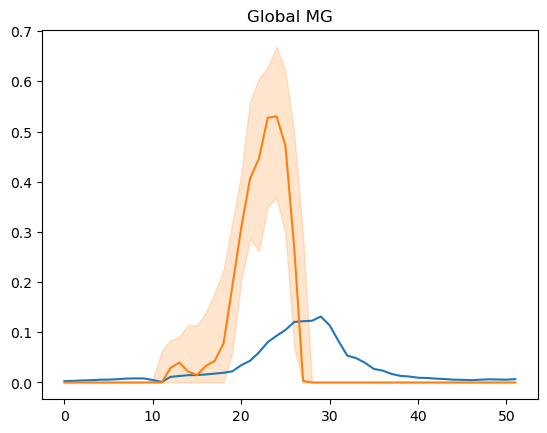

In [22]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data')

ax.plot(df_pred, label = 'preds')

ax.fill_between( np.arange(0, 52), df_pred25.values.reshape(1,-1)[0], df_pred975.values.reshape(1,-1)[0], color = 'tab:orange', alpha = 0.2)

ax.set_title('Global MG')

plt.show()

model.save(f"models/global_dengue_MG_2022.keras")
